In [1]:
import yaml
from glob import glob
import os
import SimpleITK as sitk
from scipy.ndimage import zoom
import numpy as np
from multiprocessing import Pool

config = yaml.load(open("config.yaml", "r"), Loader=yaml.FullLoader)
print(config)
train_root_list = config["input"]["train"]
test_root_list = config["input"]["test"]

processed_output_root = config["processed"]["train"]
if not os.path.exists(processed_output_root):
    os.makedirs(processed_output_root)

{'input': {'train': ['/home/medical/fanqiliang/data/Prostate/TrainingData_Part1', '/home/medical/fanqiliang/data/Prostate/TrainingData_Part2', '/home/medical/fanqiliang/data/Prostate/TrainingData_Part3'], 'test': ['/home/medical/fanqiliang/data/Prostate/TestData']}, 'processed': {'train': '/home/medical/fanqiliang/processed_data/train', 'test': '/home/medical/fanqiliang/processed_data/test'}}


In [2]:
train_files = []
train_seg_files = []
for train_root in train_root_list:
    _train_files = glob(os.path.join(train_root, "Case[0-9][0-9].mhd"))
    _seg_files = [f.replace(".mhd", "_segmentation.mhd") for f in _train_files] 
    train_files.extend(_train_files)
    train_seg_files.extend(_seg_files)

test_files = []
for test_root in test_root_list:
    test_files.extend(glob(os.path.join(test_root, "*.mhd")))

print(f"Train files: {len(train_files)}")
print(f"Test files: {len(test_files)}")

Train files: 50
Test files: 30


In [3]:
# train file


dst_shape = (64, 128, 128)

def do(idx, file, seg, save_root: str):
    img = sitk.ReadImage(file)
    seg_img = sitk.ReadImage(seg)
    assert img.GetSize() == seg_img.GetSize()
    assert img.GetSpacing() == seg_img.GetSpacing()
    arr = sitk.GetArrayFromImage(img)
    seg_arr = sitk.GetArrayFromImage(seg_img)

    arr = zoom(arr, (64 / arr.shape[0], 128 / arr.shape[1], 128 / arr.shape[2])).astype(np.float32)
    seg_arr = zoom(seg_arr, (64 / seg_arr.shape[0], 128 / seg_arr.shape[1], 128 / seg_arr.shape[2]))

    arr = (arr - arr.min()) / (arr.max() - arr.min())
    arr = (arr - arr.mean()) / arr.std()

    sitk.WriteImage(sitk.GetImageFromArray(arr), os.path.join(save_root, f"{idx}.mhd"))
    sitk.WriteImage(sitk.GetImageFromArray(seg_arr), os.path.join(save_root, f"{idx}_seg.mhd"))

params = []


for i, (file, seg) in enumerate(zip(train_files, train_seg_files)):
    params.append([i, file, seg, processed_output_root])

with Pool(16) as pool:
    pool.starmap(do, params)


In [4]:
# processed files
train_files = glob(os.path.join(processed_output_root, "*[0-9].mhd"))
train_seg_files = [v.replace(".mhd", "_seg.mhd") for v in train_files]

seg_range = set()
shape = set()

max_z, max_y, max_x = 0, 0, 0

for file, seg_file in zip(train_files, train_seg_files):
    img = sitk.ReadImage(file)
    seg_img = sitk.ReadImage(seg_file)
    arr = sitk.GetArrayFromImage(img)
    seg_arr = sitk.GetArrayFromImage(seg_img)


    idx = np.where(seg_arr > 0)
    max_z = max(max_z, max(idx[0]) - min(idx[0]))
    max_y = max(max_y, max(idx[1]) - min(idx[1]))
    max_x = max(max_x, max(idx[2]) - min(idx[2]))
    seg_range.add((max(idx[0]) - min(idx[0]), max(idx[1]) - min(idx[1]), max(idx[2]) - min(idx[2])))
    shape.add(seg_arr.shape)


(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), ar

KeyboardInterrupt: 

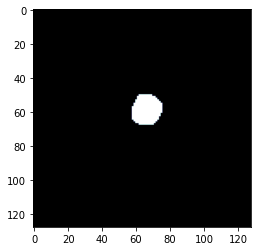

In [5]:
test_seg = train_files[0]

test_img = sitk.ReadImage(test_seg)

test_arr = sitk.GetArrayFromImage(test_img)

import matplotlib.pyplot as plt
for i, arr in enumerate(test_arr):
    plt.figure()
    plt.imshow(arr, cmap="bone")
    plt.savefig(f"{i}.png", bbox_inches="tight")
    plt.close()